# Evaluación Cuantitativa de Explicabilidad con Quantus

Este notebook evalúa cuantitativamente la calidad de las explicaciones XAI usando la librería Quantus.

**Métricas evaluadas:**
- **Fidelidad (Faithfulness)**: Faithfulness Correlation - mide si la explicación refleja el comportamiento interno del modelo.
- **Robustez (Robustness)**: Average Sensitivity - evalúa la estabilidad ante perturbaciones leves.
- **Complejidad (Complexity)**: Entropy/Complexity - estima la simplicidad de la explicación.
- **Aleatorización (Randomization)**: Randomization Test - mide la dependencia respecto a la semilla.
- **Localización (Localization)**: Region Perturbation - determina la precisión espacial.

**Métodos XAI evaluados:**
- Grad-CAM
- Grad-CAM++
- Integrated Gradients
- Saliency Maps

**Nota:** Este notebook evalúa los 3 modelos individuales (`blood`, `retina`, `breast`) y genera gráficos radar comparativos a partir de los ficheros JSON producidos por `quantus_evaluation.py`.

Comprobación de GPU (ejecutado originalmente):

```python
import torch
torch.cuda.is_available(), torch.cuda.get_device_name(0)

```

In [1]:
import sys
print(sys.executable)

/root/miniconda3/envs/py3.10/bin/python


In [2]:
import sys, numpy as np
print(sys.executable)
print(np.__version__)

/root/miniconda3/envs/py3.10/bin/python
2.2.5


In [3]:
# Configuración inicial

import os
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from math import pi

# Definir ruta absoluta del proyecto
PROJECT_DIR = Path("/home/TFM_Laura_Monne").resolve()

assert PROJECT_DIR.exists(), f"No existe el directorio del proyecto: {PROJECT_DIR}"

# Configuración de rutas
OUTPUTS_DIR = PROJECT_DIR / "outputs"
OUTPUTS_DIR.mkdir(exist_ok=True)

# Lista de datasets que vamos a usar
datasets = ["blood", "retina", "breast"]

# Número de muestras evaluadas en Quantus por dataset
NUM_SAMPLES = 30  # Aumentar implica mayor tiempo de cómputo en quantus_evaluation.py

print(f"Directorio de outputs: {OUTPUTS_DIR}")
print(f"Muestras evaluadas por dataset (Quantus): {NUM_SAMPLES}")

Directorio de outputs: /home/TFM_Laura_Monne/outputs
Muestras evaluadas por dataset (Quantus): 30


In [4]:
# Carga de resultados Quantus para los 3 datasets

results_by_dataset = {}

for dataset in datasets:
    json_path = OUTPUTS_DIR / f"quantus_metrics_{dataset}.json"
    if json_path.exists():
        with open(json_path, "r") as f:
            results_by_dataset[dataset] = json.load(f)
        print(f"✅ Cargado: {dataset} ({json_path.name})")
    else:
        print(f"⚠️  No encontrado: {json_path.name}")
        print("   Ejecuta `python quantus_evaluation.py --dataset", dataset, "...` antes de usar este notebook.")

if not results_by_dataset:
    raise ValueError("❌ No se encontraron resultados Quantus. Genera primero los ficheros JSON con quantus_evaluation.py.")

✅ Cargado: blood (quantus_metrics_blood.json)
✅ Cargado: retina (quantus_metrics_retina.json)
✅ Cargado: breast (quantus_metrics_breast.json)


In [5]:
from math import pi

# Lista de datasets que vamos a usar (por claridad)
datasets = ["blood", "retina", "breast"]

# Métricas a mostrar en los radares
metric_names = ["faithfulness", "robustness", "complexity", "localization"]
metric_labels = ["Fidelidad", "Robustez", "Complejidad", "Localización"]

# Métodos XAI
methods = ["gradcam", "gradcampp", "integrated_gradients", "saliency"]
method_labels = {
    "gradcam": "Grad-CAM",
    "gradcampp": "Grad-CAM++",
    "integrated_gradients": "Integrated Gradients",
    "saliency": "Saliency",
}


In [6]:
def build_df_for_dataset(dataset_name: str) -> pd.DataFrame:
    """Devuelve un DataFrame con las métricas *originales* de Quantus
    para un dataset concreto ("blood" / "retina" / "breast").

    - Filas: métodos XAI
    - Columnas: métricas (faithfulness, robustness, complexity, localization)
    """
    results = results_by_dataset[dataset_name]

    data = {m: [] for m in methods}
    for m in methods:
        if m not in results:
            continue
        for metric in metric_names:
            info = results[m].get(metric, None)
            if info is None:
                data[m].append(np.nan)
            else:
                data[m].append(float(info["mean"]))

    df = pd.DataFrame.from_dict(data, orient="index", columns=metric_names)
    return df


In [7]:
def plot_radar_for_dataset(dataset_name: str):
    """Dibuja un gráfico radar para un dataset (blood/retina/breast),
    normalizando cada métrica entre los métodos XAI de ese dataset.
    """
    df = build_df_for_dataset(dataset_name)

    print(f"\n=== {dataset_name.upper()} - valores originales ===")
    display(df)

    # Normalización min–max por métrica dentro del dataset
    df_norm = df.copy()

    for metric in metric_names:
        col = df[metric].values.astype(float)
        mn, mx = np.nanmin(col), np.nanmax(col)

        if mx - mn < 1e-8:
            # Si todos los métodos tienen el mismo valor en esa métrica
            df_norm[metric] = 0.5
        else:
            df_norm[metric] = (col - mn) / (mx - mn)

        # Invertimos las métricas donde "menos es mejor"
        if metric in ["robustness", "complexity"]:
            df_norm[metric] = 1.0 - df_norm[metric]

    print(f"\n=== {dataset_name.upper()} - valores normalizados (0-1) ===")
    display(df_norm)

    # Ángulos del radar
    N = len(metric_names)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # cerrar círculo

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Dibujar cada método
    for method in df_norm.index:
        vals = df_norm.loc[method, metric_names].tolist()
        vals += vals[:1]

        ax.plot(
            angles,
            vals,
            linewidth=2,
            marker="o",
            label=method_labels.get(method, method),
        )
        ax.fill(angles, vals, alpha=0.25)

    # Ejes y estética
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_labels, fontsize=12)

    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=9)

    ax.grid(True, linestyle="--", alpha=0.5)
    plt.title(
        f"Perfil de Métricas por Método XAI\nDataset: {dataset_name.upper()} (normalizado 0-1)",
        size=16,
        fontweight="bold",
        pad=20,
    )

    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize=10)
    plt.tight_layout()

    # Guardar figura
    out_path = OUTPUTS_DIR / f"quantus_radar_{dataset_name}.png"
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    print(f"✅ Figura guardada en: {out_path}")

    plt.show()



=== BLOOD - valores originales ===


,faithfulness,robustness,complexity,localization
gradcam,0.008895,0.020264,11.526514,0.276739
gradcampp,-0.003098,0.012545,11.648903,0.254500
integrated_gradients,0.189592,0.425010,11.235367,0.306706
saliency,-0.043130,0.356204,11.145209,0.467551



=== BLOOD - valores normalizados (0-1) ===


,faithfulness,robustness,complexity,localization
gradcam,0.223548,0.981286,0.242982,0.104385
gradcampp,0.172015,1.000000,0.000000,0.000000
integrated_gradients,1.000000,0.000000,0.821006,0.245041
saliency,0.000000,0.166817,1.000000,1.000000


✅ Figura guardada en: /home/TFM_Laura_Monne/outputs/quantus_radar_blood.png


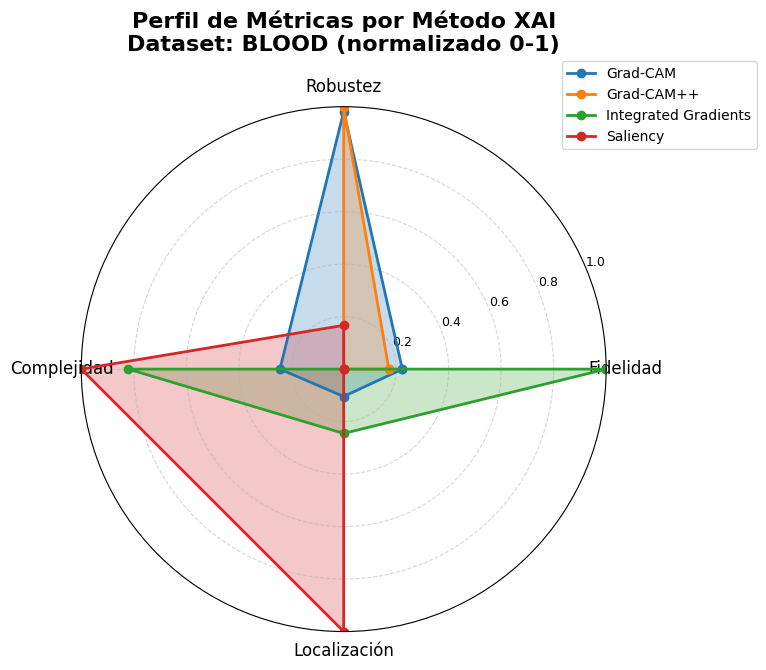


=== RETINA - valores originales ===


,faithfulness,robustness,complexity,localization
gradcam,-0.082678,0.090986,11.470676,0.009325
gradcampp,-0.077665,0.063984,11.624961,0.009963
integrated_gradients,-0.102741,0.580300,11.087545,0.042530
saliency,0.042085,0.544347,10.934252,-0.005767



=== RETINA - valores normalizados (0-1) ===


,faithfulness,robustness,complexity,localization
gradcam,0.138530,0.947704,0.223372,0.312479
gradcampp,0.173147,1.000000,0.000000,0.325688
integrated_gradients,0.000000,0.000000,0.778064,1.000000
saliency,1.000000,0.069634,1.000000,0.000000


✅ Figura guardada en: /home/TFM_Laura_Monne/outputs/quantus_radar_retina.png


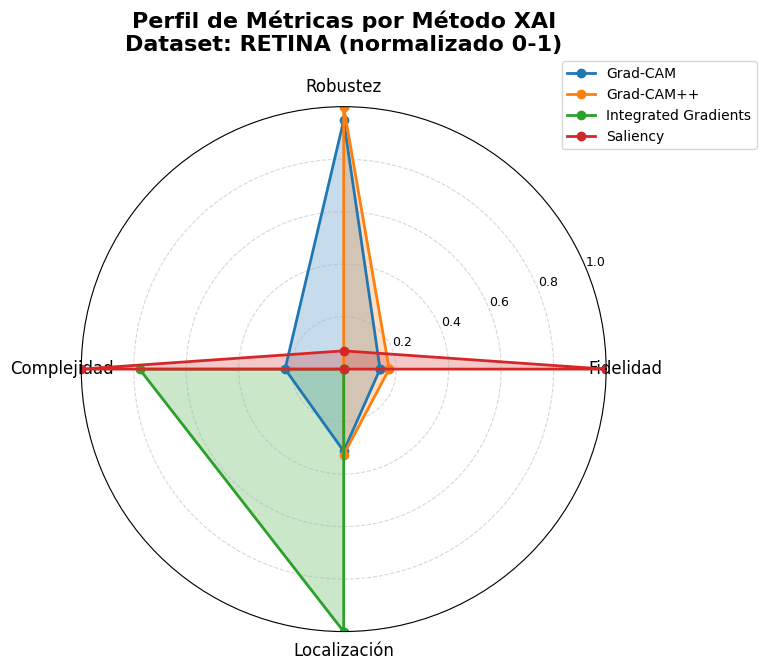


=== BREAST - valores originales ===


,faithfulness,robustness,complexity,localization
gradcam,-0.014878,0.095278,11.578883,0.062674
gradcampp,-0.019664,0.079342,11.698756,0.082613
integrated_gradients,-0.127031,0.776031,11.163041,0.079096
saliency,-0.076906,0.659700,11.196381,0.119530



=== BREAST - valores normalizados (0-1) ===


,faithfulness,robustness,complexity,localization
gradcam,1.000000,0.977126,0.223764,0.000000
gradcampp,0.957323,1.000000,0.000000,0.350685
integrated_gradients,0.000000,0.000000,1.000000,0.288840
saliency,0.446936,0.166977,0.937765,1.000000


✅ Figura guardada en: /home/TFM_Laura_Monne/outputs/quantus_radar_breast.png


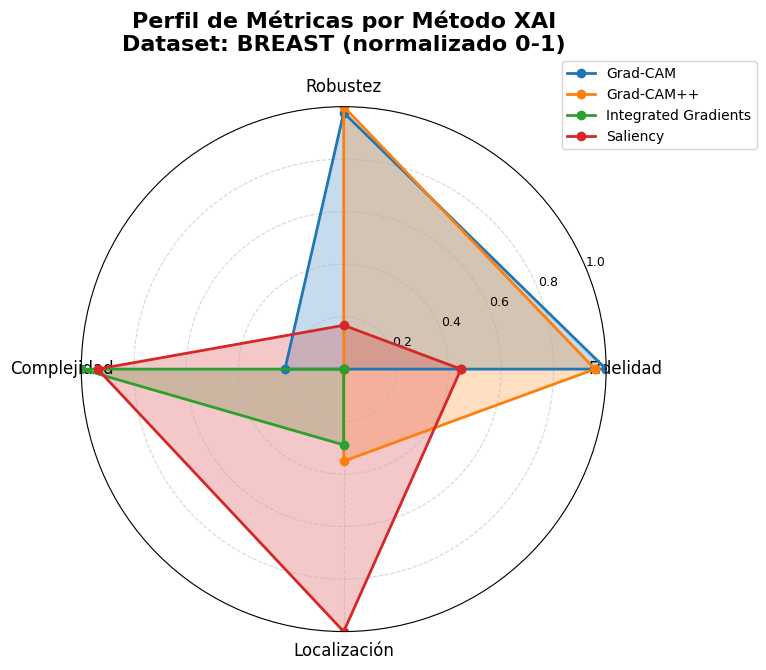

In [8]:
# Generar gráficos radar y mostrar tablas para cada dataset

for ds in datasets:
    plot_radar_for_dataset(ds)

# En este punto se generan las figuras:
# - outputs/quantus_radar_blood.png
# - outputs/quantus_radar_retina.png
# - outputs/quantus_radar_breast.png
# y se muestran en el notebook junto con las tablas de valores originales
# y normalizados que se han utilizado en el Capítulo 4 del TFM.

In [9]:
# Guardado de tablas (valores originales y normalizados) por dataset

print("\n=== Guardando tablas por dataset en outputs/ ===\n")

for dataset in datasets:
    # Construir tablas
    df_raw = build_df_for_dataset(dataset)

    # Normalización min–max por dataset
    df_norm = df_raw.copy()

    for metric in metric_names:
        col = df_raw[metric].values.astype(float)
        mn, mx = np.nanmin(col), np.nanmax(col)

        if mx - mn < 1e-8:
            df_norm[metric] = 0.5
        else:
            df_norm[metric] = (col - mn) / (mx - mn)

        if metric in ["robustness", "complexity"]:
            df_norm[metric] = 1.0 - df_norm[metric]

    # Rutas de guardado
    raw_path = OUTPUTS_DIR / f"quantus_table_raw_{dataset}.csv"
    norm_path = OUTPUTS_DIR / f"quantus_table_normalized_{dataset}.csv"

    # Guardar tablas
    df_raw.to_csv(raw_path, index=True)
    df_norm.to_csv(norm_path, index=True)

    print(f"📁 Guardado: {raw_path.name}")
    print(f"📁 Guardado: {norm_path.name}")



=== Guardando tablas por dataset en outputs/ ===

📁 Guardado: quantus_table_raw_blood.csv
📁 Guardado: quantus_table_normalized_blood.csv
📁 Guardado: quantus_table_raw_retina.csv
📁 Guardado: quantus_table_normalized_retina.csv
📁 Guardado: quantus_table_raw_breast.csv
📁 Guardado: quantus_table_normalized_breast.csv
